# DSP - Aufgabenblatt 11

## Bewertete Übung

#### FHNW - HS2021

#### Vorgaben für die Zusammenarbeit

Ihr dürft für die Lösung der Übung zusammenarbeiten, so lange sich eure **Zusammenarbeit auf konzeptionelle und algorithmische Fragestellungen beschränkt**. Bei kopiertem Code oder Text (von Mitstudierenden oder dem Internet) werden alle Lösungen der beteiligten Parteien mit 0 Punkten bewertet. Dazu werden alle Lösungen manuell und automatisiert auf Kopien untersucht.  

#### Abgabe

Arbeite auf einem eigenen Fork des Repositories `https://gitlab.fhnw.ch/ml/courses/dsp/dsp_hs2021` zu welchem du @michael.graber und @florian.schaerer als *Maintainer* hinzufügst. Committe regelmässig. Als Abgabe gilt der **letzte Commit bis Freitag, 31. Dezember 2021, 23:59:59 Uhr**.

#### Hinweise
- Der *Code* muss von Anfang bis Ende durchlaufen. Es wird nur Code bewertet, welcher beim automatischen Durchlaufen ausgeführt wird.    
- Beschrifte sämtliche Achsen (Bezeichnung und Einheit wenn möglich).  
- Ergänze den Plot mit zusätzlicher Beschriftung falls dies zum Verständnis des Plots notwendig ist.  
- Wenn du einen Plot in einer Antwort diskutierst, beginne mit einer Beschreibung dessen was der Plot zeigt.  


- Sämtliche Variablen die in einer von dir definierten Funktionen verwendet werden, müssen als Argumente übergeben oder innerhalb der Funktion definiert werden.
- Selbst definierte Funktionen müssen einen (kurzen) docstring haben.


- Versuche eine kompakte und performante Implementierung zu finden. Vollständige Punktzahl erreichst du bloss mit performantem *Code*.  
- Verwende dazu, wo immer möglich und sinnvoll, Funktionen aus `pandas` und `numpy`.
- Vermeide *Loops* falls möglich.

Am 14. April 1912 ist die Titanic vor der Küste Neufundlands auf ihrer Jungfernfahrt mit einem Eisberg kollidiert und sank kanpp 3 Stunden später in den frühen Morgenstunden des 15. Aprils. Von den ca 2224 Passagieren und Crewmitgliedern starben rund 1500.  

Auf der Website https://www.encyclopedia-titanica.org/ können Passagier- und Crewlisten runtergeladen werden. Ich habe euch zwei Dateien bereitgestellt: 'data/titanic_survivors.csv' und 'data/titanic_victims.csv'. Sie beinhalten jeweils die Überlebenden und Opfer des Unglücks.  

Wir werden in dieser Übung die Personen hinter diesem Unglück miteinander untersuchen.

### Aufgabe 1 (10 Punkte)  

Schreibe eine Funktion, mit welcher du die beiden Dateien laden und präprozessieren kannst.  

Die Funktion soll ein `DataFrame` zurückgeben mit folgenden Spalten: `'name', 'sex', 'age', 'is_adult', 'job', 'class_dept', 'is_passenger', 'joined', 'boat_body', 'ticketprice', 'survived',`.  


- Der Ticketpreis steht bei Passagieren jeweils auf der folgenden Zeile im Feld `Ticket`. Extrahiere Pfund, Shilling und Pence mittels *regular expression-matching* auf dem `DataFrame`.
- Berechne einen Dezimalbetrag in Pfund gemäss dem folgenden Satz: *'There were 12 pence in a shilling and 20 shillings in a pound.'* 
- Leite das Geschlecht `sex` aus dem Namen, insbesondere aus der Anrede, ab. Finde eine geeignete `pandas`-Methode für das *Mapping*.
- Berechnene das Alter für alle Personen in Jahren (`m` steht für *months*).
- `is_passenger` soll `True` sein, falls `class_dept` in `['1st Class Passenger', '2nd Class Passenger', '3rd Class Passenger',]` ist.  
- Sortiere das `DataFrame` nach dem Familiennamen.

Jeder *for-Loop* gibt 2 Punkte Abzug.  

Lade die Daten und gib die ersten 10 Zeilen aus.

In [10]:
import pandas as pd
import numpy as np
import re as re

#load and process file
def load(filename):
    
    #read csv as dataframe
    df = pd.read_csv(filename, skiprows=5, header=0)
    
    #create new empty dataframe
    result = pd.DataFrame(columns=["name", "sex", "age", "is_adult", "job", "class_dept", "is_passenger", "joined", "boat_body", "ticketprice", "survived"])
    
    #create a df for all people and all tickets
    people = df[df["Name"].notnull()]
    tickets = df[df["Name"].isnull() & df["Ticket"].notnull()]
    
    #fill columns
    result["name"] = people["Name"]
    result["sex"] = result["name"].apply(lambda name: sex(name))
    result["age"] = people["Age"].apply(lambda lifetime: age(lifetime))
    result["age"] = result["age"].fillna(-1).astype(int)  #fill nulls with -1 to convert column to dtype int
    result["is_adult"] = result["age"].apply(lambda age: isAdult(age))
    result["job"] = people["Job"]  
    result["class_dept"] = people["Class/Dept"]
    result["is_passenger"] = result["class_dept"].apply(lambda dept: isPassenger(dept))
    result["joined"] = people["Joined"]
    result["boat_body"] = people["Boat [Body]"]
    #re-index tickets
    tickets = tickets.set_index(tickets.index-1)
    result["ticketprice"] = tickets["Ticket"].apply(lambda price: ticketPrice(price))
    result["survived"] = True if "survivors" in filename else False
    
    #sort result by name
    result = result.sort_values(by="name")
    
    #reset indices to gapless order
    result = result.reset_index()
    result = result.drop(["index"], axis=1)
    
    #return new dataframe
    return result



#get sexuality by name
def sex(name):
    #female = Mrs | Miss | Lady | Mlle | Sra.
    #male = Mr | Sig. | Captain | Master | Colonel | ?
    femaleMatch = re.search(r'Mrs|Miss|Lady|Mlle|Sra\.', name) 
    if femaleMatch:
        return "Female"
    else:
        return "Male"

#get age
def age(lifetime):
    return lifetime if "m" not in str(lifetime) else 0

#check if adult (age >= 18)
def isAdult(age):
    if(pd.notna(age)):
        return True if int(age) >= 18 else False
    else:
        #returns None
        return

#check if it's a passenger
def isPassenger(debt):
    isPassenger = debt in ["1st Class Passenger", "2nd Class Passenger", "3rd Class Passenger"]
    return isPassenger

#get ticketprice as float
def ticketPrice(price):
    
    #regex matching for pound, shilling and pence
    pound = re.search(r'(£[0-9]*)', price).group().split("£")[1]
    shilling = re.search(r'([0-9]*s)', price)
    pence = re.search(r'([0-9]*d)', price)
    
    #init default after decimal
    afterDecimal = 0
    
    #convert shillings and pences to decimal
    if (shilling is not None):
        s = shilling.group().split("s")[0]
        afterDecimal += int(s)/20
    if (pence is not None):
        p = pence.group().split("d")[0]
        afterDecimal += int(p)/20/12
    
    #sum ticketprice
    ticketprice = int(pound) + afterDecimal
    
    #return as float
    return float(round(ticketprice, 2))



#load and process files    
victims = load('data/titanic_victims.csv')
survivors = load('data/titanic_survivors.csv')

#display first ten victims and survivor
display(victims.head(10))
display(survivors.head(10))

,name,sex,age,is_adult,job,class_dept,is_passenger,joined,boat_body,ticketprice,survived
0,"ABBING, Mr Anthony",Male,41,True,Blacksmith,3rd Class Passenger,True,Southampton,NaN,7.55,False
1,"ABBOTT, Mr Ernest Owen",Male,21,True,Lounge Pantry Steward,Victualling Crew,False,Southampton,NaN,NaN,False
2,"ABBOTT, Mr Eugene Joseph",Male,13,False,Scholar,3rd Class Passenger,True,Southampton,NaN,20.25,False
3,"ABBOTT, Mr Rossmore Edward",Male,16,False,Jeweller,3rd Class Passenger,True,Southampton,[190],20.25,False
4,"ABELSON, Mr Samuel",Male,30,True,NaN,2nd Class Passenger,True,Cherbourg,NaN,24.00,False
5,"ABRAMS, Mr William Thomas",Male,34,True,Fireman,Engineering Crew,False,Southampton,NaN,NaN,False
6,"ABĪ SA'B, Mr Jirjis Yūsuf",Male,45,True,Shoemaker,3rd Class Passenger,True,Cherbourg,[312],7.22,False
7,"ABĪ SHADĪD, Mr Dāhir",Male,19,True,NaN,3rd Class Passenger,True,Cherbourg,[9],7.22,False
8,"ADAMS, Mr John",Male,26,True,NaN,3rd Class Passenger,True,Southampton,[103],8.05,False
9,"ADAMS, Mr Robert John",Male,26,True,Fireman,Engineering Crew,False,Southampton,NaN,NaN,False


,name,sex,age,is_adult,job,class_dept,is_passenger,joined,boat_body,ticketprice,survived
0,"ABBOTT, Mrs Rhoda Mary 'Rosa'",Female,39,True,NaN,3rd Class Passenger,True,Southampton,A,20.25,True
1,"ABELSETH, Miss Karen Marie",Female,16,False,NaN,3rd Class Passenger,True,Southampton,16,7.65,True
2,"ABELSETH, Mr Olaus Jørgensen",Male,25,True,Farmer,3rd Class Passenger,True,Southampton,A,7.65,True
3,"ABELSON, Mrs Anna",Female,24,True,NaN,2nd Class Passenger,True,Cherbourg,10,24.00,True
4,"ABRAHAMSSON, Mr August Abraham Johannes",Male,19,True,NaN,3rd Class Passenger,True,Southampton,15,7.92,True
5,"ABĪ SA'B, Mrs Sha'nīnah",Female,38,True,NaN,3rd Class Passenger,True,Cherbourg,C,7.23,True
6,"ABĪ-AL-MUNÀ, Mr Nāsīf Qāsim",Male,27,True,NaN,3rd Class Passenger,True,Cherbourg,15,18.79,True
7,"AKS, Master Philip",Male,0,False,NaN,3rd Class Passenger,True,Southampton,11,9.35,True
8,"AKS, Mrs Leah",Female,21,True,NaN,3rd Class Passenger,True,Southampton,13,9.35,True
9,"AL-BA'QLĪNĪ, Miss Hilānah",Female,0,False,NaN,3rd Class Passenger,True,Cherbourg,C,19.26,True


### Aufgabe 2 (8 Punkte)

Wieviele Personen sind es insgesamt?  

Wieviele Personen ohne Ticketpreis?  

Wieviele Personen ohne Altersangabe?  

Wieviele Personen männlichen und weiblichen Geschlechts fanden sich gemäss unserem Datensatz auf der Titanic?  

Wie viele Kinder, welchen Geschlechts?  

Was war der durchschnittliche Preis für eine Fahrkarte?  

Was war das Durchschnittsalter der Besatzungsmitglieder? Was war das Durchschnittsalter der Passagiere?

In [12]:
#return all children ( < 18)
def children(data):
    persons =  data[data["age"].notnull()]
    return persons[persons["age"].astype(int) < 18]

#return all passengers or non-passenger
def passenger(data, isPassenger):
    persons =  data[data["age"].notnull()]
    return persons.age[persons["is_passenger"] == isPassenger].values

#concat dataframes
allPersons = pd.concat([victims, survivors])

#print answers
print("Anzahl Personen insgesamt: "+str(len(allPersons)))
print("Anzahl Personen ohne Ticketpreis: "+str(len(allPersons[allPersons.ticketprice.isna()])))
print("  891 davon sind Besatzungsmitglieder, und 26 sind Passagiere")
print("Anzahl Personen ohne Altersangabe: "+str(len(allPersons[allPersons.age == -1])))
print(
    "Anzahl Männer: "+str(len(allPersons[allPersons.sex == "Male"]))+", "+ 
    "Anzahl Frauen: "+str(len(allPersons[allPersons.sex == "Female"]))
     )
print("Anzahl Kinder [männlich]: "+str(len(children(allPersons[allPersons.sex == "Male"]))))
print("Anzahl Kinder [weiblich]: "+str(len(children(allPersons[allPersons.sex == "Female"]))))
print("Durchschnittlicher Ticketpreis (gerundet): "+str(np.around(np.mean(allPersons["ticketprice"]))))
print("Durchschnittsalter der Besatzungsmitglieder (gerundet): "+str(np.around(np.mean(passenger(allPersons, False).astype(int)))))
print("Durchschnittsalter der Passagiere (gerundet): "+str(np.around(np.mean(passenger(allPersons, True).astype(int)))))


Anzahl Personen insgesamt: 2208
Anzahl Personen ohne Ticketpreis: 917
  891 davon sind Besatzungsmitglieder, und 26 sind Passagiere
Anzahl Personen ohne Altersangabe: 3
Anzahl Männer: 1723, Anzahl Frauen: 485
Anzahl Kinder [männlich]: 124
Anzahl Kinder [weiblich]: 82
Durchschnittlicher Ticketpreis (gerundet): 34.0
Durchschnittsalter der Besatzungsmitglieder (gerundet): 32.0
Durchschnittsalter der Passagiere (gerundet): 30.0


### Aufgabe 3 (3 Punkte)

Erstelle eine Kreuztabelle von Einstiegsort und `class_dept`.  

Visualisiere die Tabelle.  
Wir wissen, dass die Titanic von *Belfast*, wo sie gebaut wurde, nach *Southhampton*, nach *Cherbourg* und dann nach *Queenstown* fuhr, bevor sie zur Atlantiküberfahrt auslief.  

Diskutiere deine Erkenntnisse.

joined,Belfast,Cherbourg,Queenstown,Southampton
class_dept,,,,
1st Class Passenger,4,143,3,174
2nd Class Passenger,6,26,7,245
3rd Class Passenger,0,102,113,494
Deck Crew,24,0,0,42
Engineering Crew,44,0,0,281
Restaurant Staff,0,0,0,69
Victualling Crew,122,0,0,309


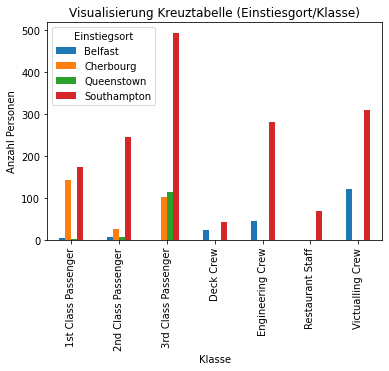

In [13]:
import matplotlib.pyplot as plt

#create cross table
joined = allPersons["joined"]
class_dept = allPersons["class_dept"]
crossTable = pd.crosstab(class_dept, joined)
#display cross table
display(crossTable)

#visualize cross table as bar chart
ax = crossTable.plot(kind="bar")
_ = ax.set_title("Visualisierung Kreuztabelle (Einstiesgort/Klasse)")
_ = ax.set_xlabel("Klasse")
_ = ax.set_ylabel("Anzahl Personen")
_ = ax.legend(title="Einstiegsort", loc="upper left")

YOUR ANSWER HERE

### Aufgabe 4 (5 Punkte)

Visualisiere die Altersverteilung für die beiden Geschlechter und gleichzeitig für die Variable `class_dept` mit Boxplots.  

Diskutiere die Visualisierung.
- Erkläre was ein Boxplot zeigt.
- Was für Information fehlt?
- Was können wir zu den vorliegenden Daten aus dieser Darstellung lesen?

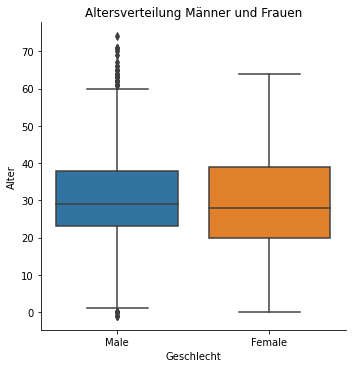

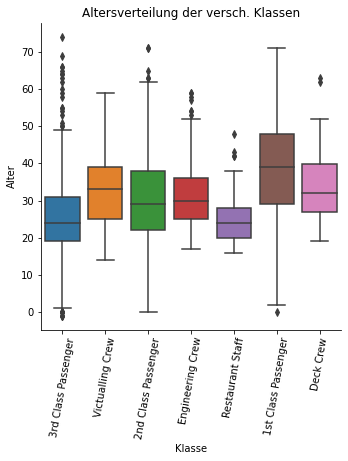

In [24]:
import seaborn as sns

#boxplot male/female
ax1 = sns.catplot(data=allPersons, x="sex", y="age", kind="box")
_ = ax1.set(xlabel='Geschlecht', ylabel='Alter', title="Altersverteilung Männer und Frauen")


#boxplot diff class_depts
ax2 = sns.catplot(data=allPersons, x="class_dept", y="age", kind="box")
_ = ax2.set(xlabel='Klasse', ylabel='Alter', title="Altersverteilung der versch. Klassen")
_ = ax2.set_xticklabels(rotation=80)

YOUR ANSWER HERE

### Aufgabe 5 (4 Punkte)

Zeichne die Verteilung des Alters sämtlicher Passagiere als Histogramm.  

Beschreibe die Verteilung bezüglich Lage, Streuung und Form.  

Du darfst verschiedene Ansätze verwenden und deren Resultate und Eigenschaften diskutieren.

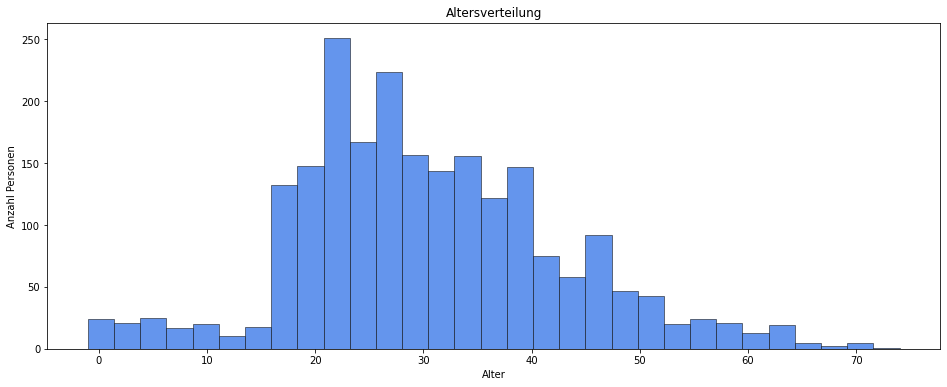

In [32]:

# histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
_ = ax.hist(allPersons["age"], bins="fd", color="cornflowerblue", edgecolor="black", linewidth=0.5)
_ = ax.set_title("Altersverteilung")
# show histogram labels
_ = ax.set_ylabel("Anzahl Personen")
_ = ax.set_xlabel("Alter")

YOUR ANSWER HERE

### Aufgabe 6 (3 Punkte)

Führe die Schritte aus Aufgabe 5 für den Ticketpreis aus.  

Visualisiere zusätzlich die kumulative Verteilung.  

Diskutiere deine Erkenntnisse.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### Aufgabe 7 (3 Punkte)

Was sind die häufigsten 10 Berufe der Passagiere, welche oberhalb des $Q_{0.9}$-Quantils des Ticketpreises liegen?  

Was sind die häufigsten 10 Berufe der Passagiere, welche unterhalb des $Q_{0.1}$-Quantils des Ticketpreises liegen?  

Wie oft kommen die Berufe jeweils vor?  
Wie interpretierst du das Resultat?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### Aufgabe 8 (6 Punkte)

Finde ein paar wenige Visualisierungen, welche es ermöglichen, kompakt einen Eindruck zu bekommen, wer das Unglück der Titanic am wahrscheinlichsten überlebt hat.  

Was sind deine Erkenntnisse?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### Aufgabe 9 (6 Punkte)

Untersuche nun, ob das Alter einen Einfluss auf die Überlebenswahrscheinlichkeit hatte.  

Teile die Passagiere dazu in Gruppen von Geschlecht und Altersjahrzenten ein.  

Visualisiere die Resultate übersichtlich und diskutiere diese.  

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE